In [11]:
import pandas as pd
import os
import string
import re
import numpy as np
from google.colab import drive

drive.mount('/content/gdrive')

!git clone https://github.com/davordavidovic/NLP-lyrics-generator.git
  
#!sudo pip install h5py


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Cloning into 'NLP-lyrics-generator'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 0), reused 22 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [0]:
def load_songs(genre, max_tokens):
    df1 = pd.read_csv('./NLP-lyrics-generator/data/lyrics_part1.csv')
    df2 = pd.read_csv('./NLP-lyrics-generator/data/lyrics_part2.csv')
    df3 = pd.read_csv('./NLP-lyrics-generator/data/lyrics_part3.csv')
    df4 = pd.read_csv('./NLP-lyrics-generator/data/lyrics_part4.csv')

    df_part_1 = pd.concat([df1, df2])
    df_part_2 = pd.concat([df3, df4])

    df = pd.concat([df_part_1, df_part_2])
    df.drop(columns=['index','Unnamed: 0'], inplace=True) #we dont need these columns

    df = df.dropna() #there were around 10000 rows with no lyrics so drop them

    df_songs = df[df.genre==genre]

    df_songs['preprocessed'] = df_songs['lyrics'].map(prepare_text)

    songs = df_songs.preprocessed.values
    
    count = 0
    cut = 0
    for i,song in enumerate(songs):
        tokens = list(song)
        count += len(tokens) 
        if count >= max_tokens:
            cut = i - 1
            break
    
    return songs[:cut]


In [0]:
def prepare_text(text):
    text = text.lower()
    text = text.replace('\n', ' N ')
  
    text = text.split()

    for index, word in enumerate(text):
        #remove non alphabetic characters at the end or beginning of a word
        #word = word.strip(string.punctuation)
    
        #replace non alhpanumeric chars with space
        word = re.sub(r"[\W]",'',word)
        text[index] = word 
   
    #concatenate again
    text = " ".join(text)
    return text

In [0]:
def build_vocab(songs):
    # create mapping of unique chars to integers
    chars = sorted(list(set(" ".join(songs))))
    char_to_int = dict((c, i) for i, c in enumerate(chars))
    return chars, char_to_int

In [0]:
def index2sen(seq,chars):
    tokens = [chars[int(t)] for t in seq]
    sen = "".join(tokens)
    return sen

In [0]:
import numpy as np

def songs_to_supervised(seq_len, songs, char_to_int):
    data_x = []
    data_y = []
    seq_chars = []
    
    for song in songs:
        tokens = list(song)
        for i in range(0, len(tokens) - seq_len):
            seq_in = tokens[i:i+seq_len]
            seq_out = tokens[i + seq_len]
            data_x.append([char_to_int[c] for c in seq_in])
            data_y.append(char_to_int[seq_out])
            seq_chars.append((seq_in,seq_out))

    return data_x, data_y, seq_chars

In [7]:

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense,Dropout, CuDNNLSTM
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential
import keras.utils as ku 

def create_model(layers, units, inp_shape, out_shape):
    #lstm sequence to categoriemodel
    model = Sequential()
  
    for l in range(layers-1):
        model.add(CuDNNLSTM(units,return_sequences=True, input_shape = inp_shape))
        model.add(Dropout(0.2))
    
    model.add(CuDNNLSTM(units,return_sequences=False))
    model.add(Dropout(0.2)) 
    model.add(Dense(out_shape, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['categorical_accuracy'])
  
    return model


Using TensorFlow backend.


In [0]:
def generate_text(seed_text, next_chars, model, chars, chars_to_int):
    seq_in = list(seed_text)
    x = np.array([chars_to_int[c] for c in seq_in])
    predictions = []
    for i in range(next_chars):
        input_seq = np.reshape(np.append(x[i:],predictions),(1,len(x),1))
        predicted = model.predict_classes(input_seq, verbose=0)
        predictions.append(predicted[0])
        output_char = chars[predicted[0]]
        seed_text += " " + output_char
        
    return seed_text



In [0]:
from keras.utils import np_utils
import numpy as np 
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pickle
 

def run_experiment(n_sequences, n_epochs, genre, seq_len, n_layers, directory):

    print("Running", n_sequences,"sequences", n_epochs,"epochs",genre, seq_len,"sequence length", n_layers, "layers", "vocab size", directory, "directory") 

    #load lyrics with this many tokens
    max_tokens = n_sequences-seq_len

    #load song lyrics
    songs = load_songs(genre, max_tokens)

    #create the vocabulary from the songs 
    chars, chars_to_int = build_vocab(songs)
    n_vocab = len(chars)
    #songs to sequences and labels
    data_x, data_y, seq_chars = songs_to_supervised(seq_len, songs, chars_to_int)
    
    #reshape input to samples, timesteps, features
    X = np.reshape(data_x, (len(data_x), seq_len, 1))
    #normalize input
    X = X/float(n_vocab)
    #categorical labels 
    y = np_utils.to_categorical(data_y)

    inp_shape = X[0].shape
    out_shape = y[0].shape[0]
    print("X shape",X.shape)
    #create the lstm model
    model = create_model(n_layers, units=400, inp_shape =inp_shape, out_shape=out_shape)

    # checkpoint
    #TODO adapt filepath
    filepath = directory + "weights-improvement-{epoch:02d}-{acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='min')

    #early stopping 
    es = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=50)

    callbacks_list = [es]

    #train model
    history = model.fit(X, y, epochs=n_epochs, verbose=1,batch_size=1024,callbacks=callbacks_list, validation_split=0.1)

    #save model TODO namin
    model.save(directory +"model.h5")

    #save history
    with open(directory+"hist", 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    #generate validation texts and training texts
    val_chars = seq_chars[-5:]
    for t in val_chars:
        sentence = "".join(t[0])
        label = t[1]
        output = generate_text(sentence, next_chars = seq_len, model = model, chars=chars, chars_to_int=chars_to_int)
        with open(directory + "generated.txt","w") as file:
            print(sentence + " out: " + output)
            file.write(sentence + " out: " + output + "\n")
            #also save the actual number of sequences that were used
            file.write(str(len(data_x)))
  
  
    #TODO save plot on training curve
    plt.plot(history.history['categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'test'], loc='upper left')
    plot_path = directory + "plot.png"
    plt.savefig(plot_path, bbox_inches='tight', format='png')

Running 3 experiments
Running 100000 sequences 70 epochs Hip-Hop 5 sequence length 4 layers vocab size ./gdrive/My Drive/Colab Notebooks/exps3/_slen5 directory


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


X shape (97378, 5, 1)
Train on 87640 samples, validate on 9738 samples
Epoch 1/70
87640/87640 [==============================] - 6s 68us/step - loss: 2.9593 - categorical_accuracy: 0.2180 - val_loss: 2.8881 - val_categorical_accuracy: 0.2295
Epoch 2/70
 3072/87640 [>.............................] - ETA: 4s - loss: 2.8925 - categorical_accuracy: 0.2168

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_categorical_accuracy,loss,categorical_accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


87640/87640 [==============================] - 5s 55us/step - loss: 2.8900 - categorical_accuracy: 0.2207 - val_loss: 2.8900 - val_categorical_accuracy: 0.2295
Epoch 3/70
87640/87640 [==============================] - 5s 55us/step - loss: 2.8880 - categorical_accuracy: 0.2207 - val_loss: 2.8895 - val_categorical_accuracy: 0.2295
Epoch 4/70
87640/87640 [==============================] - 5s 56us/step - loss: 2.8755 - categorical_accuracy: 0.2207 - val_loss: 2.8452 - val_categorical_accuracy: 0.2276
Epoch 5/70
87640/87640 [==============================] - 5s 56us/step - loss: 2.7175 - categorical_accuracy: 0.2413 - val_loss: 2.5924 - val_categorical_accuracy: 0.2753
Epoch 6/70
87640/87640 [==============================] - 5s 56us/step - loss: 2.5244 - categorical_accuracy: 0.2827 - val_loss: 2.4246 - val_categorical_accuracy: 0.3086
Epoch 7/70
87640/87640 [==============================] - 5s 56us/step - loss: 2.3555 - categorical_accuracy: 0.3191 - val_loss: 2.2393 - val_categorical_ac

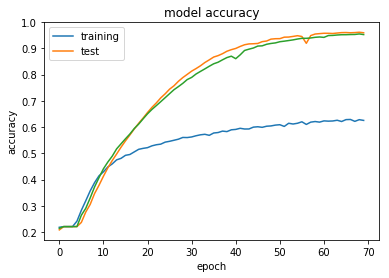

In [14]:
data_sizes = [10000, 100000, 250000] #num of sequences
epochs = [5,70]
genres = ['Pop', 'Hip-Hop', 'Metal', 'Country']
seq_lens = [5,20,30]
layers = [4, 8] #400 units each

experiments = []
 
#big dataset on all genres with different vocabulary sizes
for s in seq_lens:
    exp = {"seqs" : data_sizes[1],
           "epochs" : epochs[1],
           "genre" : genres[1],
           "seq_lens" : s,
           "layers" : layers[0],
           "dir" : "./gdrive/My Drive/Colab Notebooks/exps3/_slen" +  str(s)
          }
    experiments.append(exp)
'''
#big dataset on all genres with different vocabulary sizes
for g in genres:
    exp = {"seqs" : data_sizes[2],
           "epochs" : epochs[1],
           "genre" : g,
           "seq_lens" : seq_lens[2],
           "layers" : layers[0],
           "dir" : "exps3/_250000_100e_30seq_" +  g
          }
    experiments.append(exp)
'''  
print("Running", len(experiments), "experiments")
            
for e in experiments:
    #try:
        n_seqs = e["seqs"]
        n_epochs = e["epochs"]
        genre = e["genre"]
        seq_len = e["seq_lens"]
        n_layers = e["layers"]
        dir_ = e["dir"]
        run_experiment(n_sequences = n_seqs, n_epochs = n_epochs, genre = genre, seq_len = seq_len, n_layers = n_layers, directory = dir_)
    #except Exception as ex:
     #   print(ex)
      #  pass